# Springboard Time Series - 'Cowboy Cigarettes' Case Study - Tier 3

## Brief

You're working in the US federal government as a data scientist in the Health and Environment department. You've been tasked with determining whether sales for the oldest and most powerful producers of cigarettes in the country are increasing or declining. 

**Cowboy Cigarettes (TM, *est.* 1890)** is the US's longest-running cigarette manufacturer. Like many cigarette companies, however, they haven't always been that public about their sales and marketing data. The available post-war historical data runs for only 11 years after they resumed production in 1949; stopping in 1960 before resuming again in 1970. Your job is to use the 1949-1960 data to predict whether the manufacturer's cigarette sales actually increased, decreased, or stayed the same. You need to make a probable reconstruction of the sales record of the manufacturer - predicting the future, from the perspective of the past - to contribute to a full report on US public health in relation to major cigarette companies. 

The results of your analysis will be used as part of a major report relating public health and local economics, and will be combined with other studies executed by your colleagues to provide important government advice.  

-------------------------------
As ever, this notebook is **tiered**, meaning you can elect that tier that is right for your confidence and skill level. There are 3 tiers, with tier 1 being the easiest and tier 3 being the hardest.  

**1. Sourcing and loading** 
- Load relevant libraries 
- Load the data
- Explore the data

 
**2. Cleaning, transforming and visualizing**
- Dropping unwanted columns
- Nomenclature
- Type conversions
- Making a predictor variable `y` 
- Getting summary statistics for `y`
- Plotting `y`
  
  
**3. Modelling** 
- Decomposition
    - Trend
    - Seasonality
    - Noise
- Testing for stationarity with KPSS
- Making the data stationary
- The ARIMA Model
    - Make a function to find the MSE of a single ARIMA model
    - Make a function to evaluate the different ARIMA models with different p, d, and q values
- Visualize the results
- Application: Forecasting

**4. Evaluating and concluding** 
- What is our conclusion?
- Next steps
    

## 0. Preliminaries 

Time series data is just any data displaying how a single variable changes over time. It comes as a collection of metrics typically taken at regular intervals. Common examples of time series data include weekly sales data and daily stock prices. You can also easily acquire time series data from [Google Trends](https://trends.google.com/trends/?geo=US), which shows you how popular certain search terms are, measured in number of Google searches. 

## 1. Sourcing and Loading

### 1a. Load relevant libraries 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sklearn.model_selection
import datetime
import sklearn.linear_model
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

### 1b. Load the data
Call the variable `cigData`. 

In [2]:
cigData = pd.read_csv('CowboyCigsData.csv')

### 1c. Explore the data
We now need to check whether the data conduces to a time series style analysis.

In [3]:
cigData.head()

,Unnamed: 0,Time,#CigSales
0,0,1949-01,1000112
1,1,1949-02,1000118
2,2,1949-03,1000132
3,3,1949-04,1000129
4,4,1949-05,1000121


In [4]:
#based on an alum from springboard, they said 
#to fix how the cigData doesn't scale correctly when 
#using log later on, to do the following "subtract a million 
#and multiple the difference by 100,000"

cigData['#CigSales'] = (cigData['#CigSales'] - 1000000) * 100000

Over a million cigarettes sold in the month of January 1949. This certainly is a popular cigarette brand. 

Check out the columns feature of the data. How many columns are there? 

In [5]:
cigData.columns

Index(['Unnamed: 0', 'Time', '#CigSales'], dtype='object')

Let's check out the data types of our columns.

In [6]:
cigData.dtypes

Unnamed: 0     int64
Time          object
#CigSales      int64
dtype: object

Check whether there are any null values. 

In [7]:
#output should be a list of # of null values within a column
cigData.isnull().sum()

Unnamed: 0    0
Time          0
#CigSales     0
dtype: int64

## 2. Cleaning, transforming and visualizing

### 2a. Dropping unwanted columns
We need to cut that `Unnamed: 0` column. Delete it here.

In [8]:
cigData = cigData.drop(columns=['Unnamed: 0'])

### 2b. Nomenclature

We can see that the `Time` column actually has the granularity of months. Change the name of that column to `Month`.

In [9]:
cigData = cigData.rename(columns={"Time": "Month"})

Call a head() to check this has worked. 

In [10]:
cigData.head()

,Month,#CigSales
0,1949-01,11200000
1,1949-02,11800000
2,1949-03,13200000
3,1949-04,12900000
4,1949-05,12100000


### 2c. Type conversions 

Now, do time series analysis on a Pandas dataframe is overkill, and is actually counter-productive. It's much more easy to carry out this type of analysis if we convert our data to a series first.

Notice that the `Month` field was an object. Let's type convert the `Month` column to a Python `datetime`, before making that the index.

In [11]:
cigData['Month'] = pd.to_datetime(cigData['Month'])

In [12]:
cigData.dtypes

Month        datetime64[ns]
#CigSales             int64
dtype: object

In [13]:
cigData.head()

,Month,#CigSales
0,1949-01-01,11200000
1,1949-02-01,11800000
2,1949-03-01,13200000
3,1949-04-01,12900000
4,1949-05-01,12100000


Perfect! 

### 2d. Making a predictor variable `y`

The data is now indexed by date, as time series data ought to be.

Since we want to predict the number of cigarette sales at Cowboy cigarettes, and `y` is typically used to signify a predictor variable, let's create a new variable called `y` and assign the indexed #Passenger column. 

In [14]:
y = cigData['#CigSales']

Check the type of our new variable. 

In [15]:
y.dtype

dtype('int64')

### 2e. Getting summary statistics for `y`

Get the summary statistics of our data here. 

In [16]:
y.describe()

count    1.440000e+02
mean     2.802986e+07
std      1.199663e+07
min      1.040000e+07
25%      1.800000e+07
50%      2.655000e+07
75%      3.605000e+07
max      6.220000e+07
Name: #CigSales, dtype: float64

Try visualizing the data. A simple `matplotlib` plot should do the trick.  

### 2f. Plotting `y`

In [17]:
X = cigData['Month']

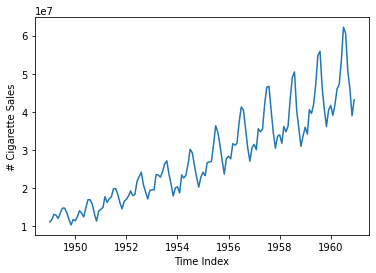

In [18]:
plt.plot(X,y)
plt.xlabel('Time Index')
plt.ylabel('# Cigarette Sales')
plt.show()

## 3. Modelling 
### 3a. Decomposition
What do you notice from the plot? Take at least `2` minutes to examine the plot, and write down everything you observe.  

All done?

We can see that, generally, there is a trend upwards in cigarette sales from at Cowboy Cigarettes. But there are also some striking - and perhaps unexpected - seasonal fluctuations. These seasonal fluctations come in a repeated pattern. Work out when these seasonal fluctuations are happening, and take 2 minutes to hypothesize on their cause here.

What does it mean to *decompose* time series data? It means breaking that data into 3 components: 

1. **Trend**: The overall direction that the data is travelling in (like upwards or downwards)
2. **Seasonality**: Cyclical patterns in the data 
3. **Noise**: The random variation in the data

We can treat these components differently, depending on the question and what's appropriate in the context. They can either be added together in an *additive* model, or multiplied together in a *multiplicative* model. 

Make a coffee, take `5` minutes and read [this article](https://medium.com/@sigmundojr/seasonality-in-python-additive-or-multiplicative-model-d4b9cf1f48a7) and think about whether our data would conduce to an additive or multiplicative model here. Write your conclusion down just here: 

-------------------------------

#### The data is a multiplicative model; y's value over time as x increases, shows an increasing amplitude. The magnitude of seasonality changes! If it were the same amplitude that occured seasonally, then we'd potentially have a case for an additive model. Note to self: There's a mistake in the article, where they try to show the difference between additive and multiplicative plots. They show the same data twice.

All done? Well, just on the basis of the plot above, it seems our Cowboy Cigarettes data is actually multiplicative. 

That's because, as time progresses, the general trend seems to be increasing *at a rate that's also increasing*. We also see that the seasonal fluctuations (the peaks and troughs) get bigger and bigger as time progresses.

Now on the other hand, if the data were simply additive, we could expect the general trend to increase at a *steadily*, and a constant speed; and also for seasonal ups and downs not to increase or decrease in extent over time.

Happily, we can use the `decompose()` function to quantify the component parts described above in our data.

In [19]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [20]:
cigData = cigData.set_index('Month')

In [21]:
cigData.head()

,#CigSales
Month,
1949-01-01,11200000
1949-02-01,11800000
1949-03-01,13200000
1949-04-01,12900000
1949-05-01,12100000


<AxesSubplot:title={'center':'Residual IDs'}, xlabel='Month'>

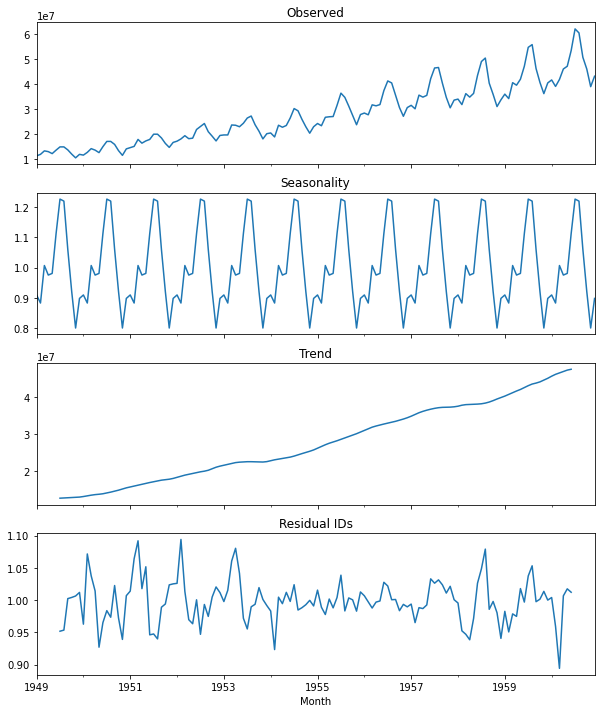

In [22]:
#y = cigData['#CigSales'].resample('M').sum()
y = cigData['#CigSales']
# Plot the original data, the trend, the seasonality, and the residuals 
decomposition = seasonal_decompose(y, model='multiplicative')

fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize=(10,12), sharex=True)

decomposition.observed.plot(ax=ax1, title='Observed')
decomposition.seasonal.plot(ax=ax2, title='Seasonality')
decomposition.trend.plot(ax=ax3, title='Trend')
decomposition.resid.plot(ax=ax4, title='Residual IDs')

In [23]:
cigData.head()

,#CigSales
Month,
1949-01-01,11200000
1949-02-01,11800000
1949-03-01,13200000
1949-04-01,12900000
1949-05-01,12100000


In [24]:
cigData.head(-5)

,#CigSales
Month,
1949-01-01,11200000
1949-02-01,11800000
1949-03-01,13200000
1949-04-01,12900000
1949-05-01,12100000
...,...
1960-03-01,41900000
1960-04-01,46100000
1960-05-01,47200000


### 3b. Testing for stationarity with KPSS
As you know, when doing time series analysis we always have to check for stationarity. Imprecisely, a time series dataset is stationary just if its statistical features don't change over time. A little more precisely, a stationary time series dataset will have constant mean, variance, and covariance.

There are many ways to test for stationarity, but one of the most common is the KPSS test. The Null hypothesis of this test is that the time series data in question is stationary; hence, if the *p*-value is less than the significance level (typically 0.05, but we decide) then we reject the Null and infer that the data is not stationary.

In [25]:
from statsmodels.tsa.stattools import kpss

def kpss_test(series, **kw):    
    statistic, p_value, n_lags, critical_values = kpss(series, **kw)
    # Format Output
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')
    print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary')

kpss_test(cigData)

KPSS Statistic: 1.052175011013511
p-value: 0.01
num lags: 14
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is not stationary


C:\Users\18572\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
C:\Users\18572\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
C:\Users\18572\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence th

Since our p-value is less than 0.05, we should reject the Null hypothesis and deduce the non-stationarity of our data. 

But our data need to be stationary! So we need to do some transforming.

#### It makes sense that the data isn't stationary, as it's multiplicative in nature. The seasonal amplitude changing is a key indicator of non-stationarity.

### 3c. Making the data stationary 
Let's recall what it looks like. 

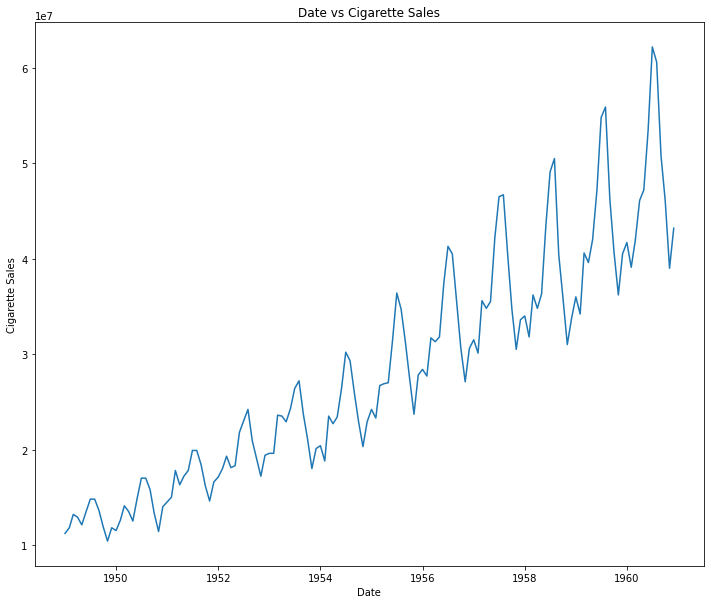

In [26]:
plt.figure(figsize=(12,10))
plt.xlabel('Date')
plt.ylabel('Cigarette Sales')
plt.title('Date vs Cigarette Sales')
plt.plot(X,y)
plt.show()

In our plot, we can see that both the mean and the variance *increase as time progresses*. At the moment, our data has neither a constant mean, nor a constant variance (the covariance, however, seems constant). 

One often  used way of getting rid of changing variance is to take the natural log of all the values in our dataset. Let's do this now. 

In [27]:
y = np.log(y)


When you plot this, you can see how the variance in our data now remains contant over time.

Text(0, 0.5, 'Cigarette Sales')

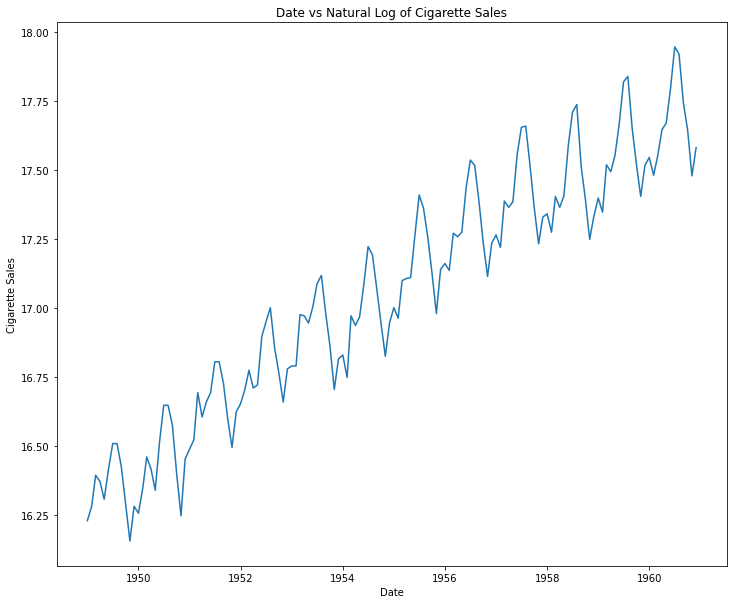

In [28]:
plt.figure(figsize=(12,10))
plt.plot(X,y)
plt.title('Date vs Natural Log of Cigarette Sales')
plt.xlabel('Date')
plt.ylabel('Cigarette Sales')

One thing to note is that after performing the logarithmic transformation on the data's # of Cigarette sales, the seasonal variance no longer increases with time. The amplitude of the wave like shape it takes seems to be constant. We'll see below what happens when we now plot a histogram of the change that has occured to the data before and after being logarithmically transformed.

What does this mean? Although the data shown above for the cigarette sales show an upward trend, that does not mean that data can't be stationary. Looking at the above, what's plotted is a line plot between each month within a year from the time period of 1949 to 1960. From a month to month examination, we see that the there's an upward trend. But maybe with differencing via some number of months, can we reduce the data to show a graph that appears more like white noise, or has a sine function like shape.

From looking at the consistent major peak occurences, it appears it's possible the period of interest is 12 months. We need to utilize differencing in order to get rid of trends and stabilize the mean of the data.

In [29]:
print(cigData)

            #CigSales
Month                
1949-01-01   11200000
1949-02-01   11800000
1949-03-01   13200000
1949-04-01   12900000
1949-05-01   12100000
...               ...
1960-08-01   60600000
1960-09-01   50800000
1960-10-01   46100000
1960-11-01   39000000
1960-12-01   43200000

[144 rows x 1 columns]


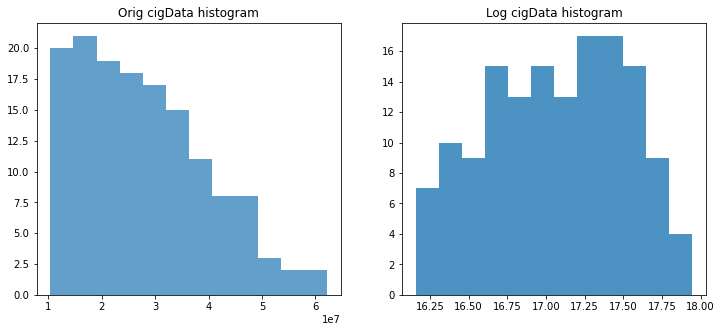

In [30]:
plt.figure(figsize=(12,5))

plt.subplot(121)
plt.title('Orig cigData histogram')
plt.hist(cigData, bins=12, alpha=0.7)

plt.subplot(122)
plt.title('Log cigData histogram')
plt.hist(y, bins=12, alpha=0.8)

plt.show()

Using histograms we can visualize what has happened to our data after performing a power transformation, we can see in the example that the skew has changed and that the log transformed data now appears to be more uniform in shape

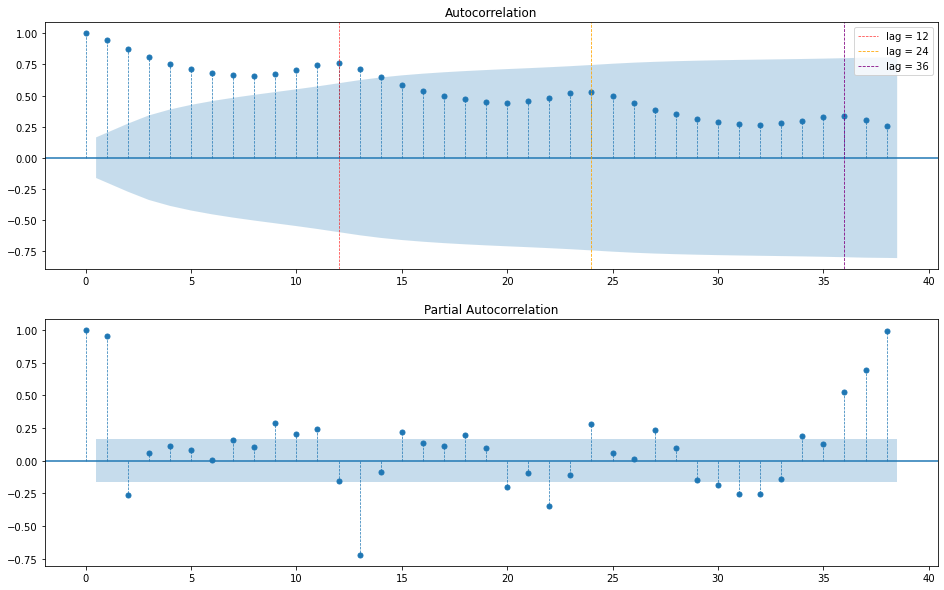

In [31]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(2, figsize=(16,10))

# plot the ACF
plot_acf(cigData, ax=ax[0], vlines_kwargs={'ls':'--', 'linewidth': 0.7}, lags=38)

# place marker lines on lags 12 and 24 to highligh the period of seasonality
ax[0].axvline(12, color='red', ls='--', alpha=0.8, lw=0.7, label='lag = 12')
ax[0].axvline(24, color='orange', ls='--', alpha=1, lw=0.8, label='lag = 24')
ax[0].axvline(36, color='purple', ls='--', alpha=1, lw=0.8, label='lag = 36')
ax[0].legend()

# plot the PACF
plot_pacf(cigData, ax=ax[1], vlines_kwargs={'ls':'--', 'linewidth': 0.7}, lags=38)

plt.show()

Examining the above ACF and PACF plots, although typically they are done when assuming that the data is stationary, we can use it examine the relationship of the data between different time points. We can see that peaks tend to occur every 12 months, so this may be a key number when we are trying to make our non-stationary data, stationary.

We now have a constant variance, but we also need a constant mean.

We can do this by *differencing* our data. We difference a time series dataset when we create a new time series comprising the difference between the values of our existing dataset.

Python is powerful, and we can use the `diff()` function to do this. You'll notice there's one less value than our existing dataset (since we're taking the difference between the existing values).

In [32]:
#trying a difference of 12
#trying various differences

#differencing by 1 month
y_diff1 = y.diff().dropna()
#differencing by quarters (every 3 months)
y_diff3 = y.diff(3).dropna()
#differencing bi-annually (every 6 months)
y_diff6 = y.diff(6).dropna()
#differencing annually (every 12 months)
y_diff12 = y.diff(12).dropna()

In [33]:
#generating time indexes, that account for the # of NaNs generated by the differencing period
X_diff1 = X.iloc[1:]
X_diff3 = X.iloc[3:]
X_diff6 = X.iloc[6:]
X_diff12 = X.iloc[12:]

Text(0, 0.5, 'Cigarette Sales')

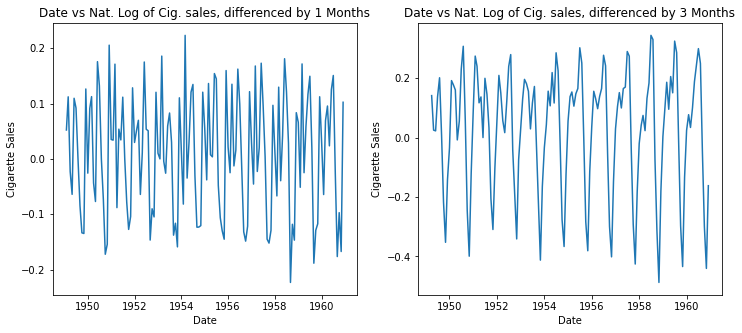

In [34]:
#the periods in the time index, is monthly accounts from the years of 1950
plt.figure(figsize=(12,5))

plt.subplot(121)
plt.plot(X_diff1,y_diff1)
plt.title('Date vs Nat. Log of Cig. sales, differenced by 1 Months')
plt.xlabel('Date')
plt.ylabel('Cigarette Sales')

plt.subplot(122)
plt.plot(X_diff3,y_diff3)
plt.title('Date vs Nat. Log of Cig. sales, differenced by 3 Months')
plt.xlabel('Date')
plt.ylabel('Cigarette Sales')

Text(0, 0.5, 'Cigarette Sales')

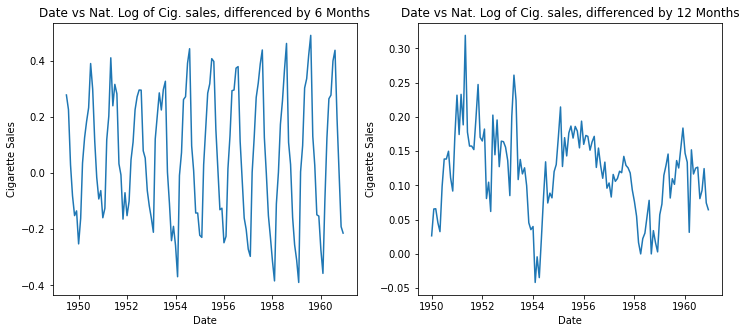

In [35]:
plt.figure(figsize=(12,5))

plt.subplot(121)
plt.plot(X_diff6,y_diff6)
plt.title('Date vs Nat. Log of Cig. sales, differenced by 6 Months')
plt.xlabel('Date')
plt.ylabel('Cigarette Sales')

plt.subplot(122)
plt.plot(X_diff12,y_diff12)
plt.title('Date vs Nat. Log of Cig. sales, differenced by 12 Months')
plt.xlabel('Date')
plt.ylabel('Cigarette Sales')

Same plots as above, but with rolling accounting for the number of months differenced.

Below are graphs of the differenced cigData but with rolling means


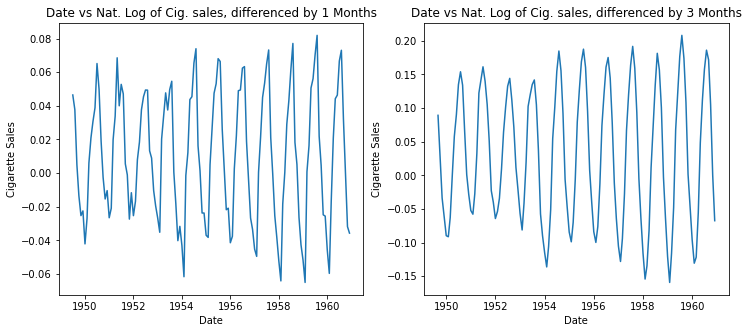

In [36]:
#Note to self, the differences, are by lags, however in this case, each lag = 1 month.


plt.figure(figsize=(12,5))

plt.subplot(121)
plt.plot(X_diff1,(y_diff1.rolling(6).mean()))
plt.title('Date vs Nat. Log of Cig. sales, differenced by 1 Months')
plt.xlabel('Date')
plt.ylabel('Cigarette Sales')

plt.subplot(122)
plt.plot(X_diff3,(y_diff3.rolling(6).mean()))
plt.title('Date vs Nat. Log of Cig. sales, differenced by 3 Months')
plt.xlabel('Date')
plt.ylabel('Cigarette Sales')

print('Below are graphs of the differenced cigData but with rolling means')

Below are graphs of the differenced cigData but with rolling means


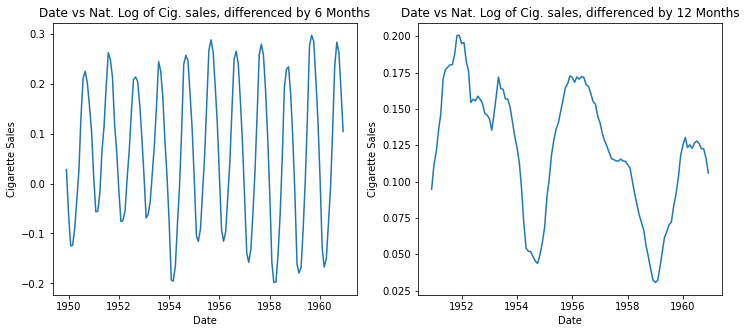

In [37]:
plt.figure(figsize=(12,5))

plt.subplot(121)
plt.plot(X_diff6,(y_diff6.rolling(6).mean()))
plt.title('Date vs Nat. Log of Cig. sales, differenced by 6 Months')
plt.xlabel('Date')
plt.ylabel('Cigarette Sales')

plt.subplot(122)
plt.plot(X_diff12,(y_diff12.rolling(12).mean()))
plt.title('Date vs Nat. Log of Cig. sales, differenced by 12 Months')
plt.xlabel('Date')
plt.ylabel('Cigarette Sales')

print('Below are graphs of the differenced cigData but with rolling means')

In [40]:
y_diff12rolled = y_diff12.rolling(12).mean().dropna()

In [41]:
y_diff12rolled = y_diff12rolled.dropna()

In [42]:
#when rolling, the first # of values within the window we are rolling by
#will be NaN. For example, we are rolling(12), the first 12 values were NaN, thus we dropped it, in the code above.
kpss_test(y_diff12rolled)

KPSS Statistic: 0.3260469154265472
p-value: 0.1
num lags: 13
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary


C:\Users\18572\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
C:\Users\18572\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


Our p-value is now greater than 0.05, so we can accept the null hypothesis that our data is stationary.

### 3d. The ARIMA model

Recall that ARIMA models are based around the idea that it's possible to predict the next value in a time series by using information about the most recent data points. It also assumes there will be some randomness in our data that can't ever be predicted.

We can find some good parameters for our model using the `sklearn` and `statsmodels` libraries, and in particular `mean_squared_error` and `ARIMA`. 

In [43]:
# Import mean_squared_error and ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA
#Frank(alum/mentor) from springboard recommended to use SARIMAX
#because the dataset has seasonality
from statsmodels.tsa.statespace.sarimax import SARIMAX

#### 3di. Make a function to find the MSE of a single ARIMA model
Things get intricate here. Don't worry if you can't do this yourself and need to drop down a Tier. 

In [44]:
# Make a function called evaluate_arima_model to find the MSE of a single ARIMA model 
#data in this case just needs to be the transformed y data that has been
#made stationary
def evaluate_arima_model(data, arima_order):
    # Needs to be an integer because it is later used as an index.
    # Use int()
    split=int(len(data) * 0.8) 
    # Make train and test variables, with 'train, test'
    train, test = data[0:split], data[split:len(data)]
    past=[x for x in train]
    # make predictions. Declare a variable with that name
    predictions = list()
    for i in range(len(test)):#timestep-wise comparison between test data and one-step prediction ARIMA model. 
        #note the ARIMA(endog, order=(p,d,q)), where
        #endog= observed time-series process y
        model = ARIMA(past, order=arima_order)
        model_fit = model.fit(disp=0)
        future = model_fit.forecast()[0]
        # Append() here
        predictions.append(future)
        past.append(test[i])
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    # Return the error
    return error

#### 3dii. Make a function to evaluate the different ARIMA models with different p, d, and q values

In [45]:
# Make a function to evaluate different ARIMA models with several different p, d, and q values.
def evaluate_models(dataset, p_values, d_values, q_values):
    best_score, best_cfg = float("inf"), None
    # Iterate through p_values
    for p in p_values:
        # Iterate through d_values
        for d in d_values:
            # Iterate through q_values
            for q in q_values:
                # p, d, q iterator variables in that order
                order = (p, d, q)
                try:
                    # Make a variable called mse for the Mean squared error
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.3f' % (order,mse))
                except:
                    continue
    return print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

In [46]:
# Now, we choose a couple of values to try for each parameter.
p_values = [x for x in range(0, 3)]
d_values = [x for x in range(0, 3)]
q_values = [x for x in range(0, 3)]

In [47]:
# Finally, we can find the optimum ARIMA model for our data.
# Nb. this can take a while...!
import warnings
warnings.filterwarnings("ignore")
evaluate_models(y_diff12, p_values, d_values, q_values)

ARIMA(0, 0, 0) MSE=0.002
ARIMA(0, 0, 1) MSE=0.002
ARIMA(0, 0, 2) MSE=0.001
ARIMA(0, 1, 0) MSE=0.002
ARIMA(0, 1, 1) MSE=0.002
ARIMA(0, 1, 2) MSE=0.002
ARIMA(0, 2, 0) MSE=0.006
ARIMA(0, 2, 1) MSE=0.002
ARIMA(0, 2, 2) MSE=0.002
ARIMA(1, 0, 0) MSE=0.001
ARIMA(1, 1, 0) MSE=0.002
ARIMA(1, 2, 0) MSE=0.003
ARIMA(2, 0, 0) MSE=0.001
ARIMA(2, 1, 0) MSE=0.002
ARIMA(2, 2, 0) MSE=0.002
Best ARIMA(2, 0, 0) MSE=0.001


So the best p,d, q, parameters for our ARIMA model are 2, 1, 1 respectively. Now we know this, we can build the model.

In [48]:
p = 2
d = 0
q = 0
model = ARIMA(y_diff12, order=(p,d,q))
model_fitted = model.fit()
#the number 24, means we'll be forecasting out for 24 months, or 2 years
forecast = model_fitted.forecast(24)

In [49]:
forecast[0]

array([0.07741978, 0.08218692, 0.08789122, 0.09218519, 0.09592067,
       0.09901134, 0.10161195, 0.10378773, 0.1056116 , 0.10713948,
       0.10841969, 0.10949229, 0.11039098, 0.11114394, 0.11177481,
       0.11230339, 0.11274626, 0.11311731, 0.11342821, 0.11368869,
       0.11390693, 0.11408978, 0.11424299, 0.11437135])

In [50]:
y_diff12

Month
1950-01-01    0.026433
1950-02-01    0.065597
1950-03-01    0.065958
1950-04-01    0.045462
1950-05-01    0.032523
                ...   
1960-08-01    0.080731
1960-09-01    0.092754
1960-10-01    0.124585
1960-11-01    0.074503
1960-12-01    0.064539
Name: #CigSales, Length: 132, dtype: float64

We can take a look at a summary of the model this library has built around our data.

In [51]:
model_fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:              #CigSales   No. Observations:                  132
Model:                     ARMA(2, 0)   Log Likelihood                 233.131
Method:                       css-mle   S.D. of innovations              0.041
Date:                Tue, 29 Nov 2022   AIC                           -458.262
Time:                        19:32:20   BIC                           -446.731
Sample:                    01-01-1950   HQIC                          -453.577
                         - 12-01-1960                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.1150      0.017      6.879      0.000       0.082       0.148
ar.L1.#CigSales     0.5540      0.084      6.557      0.000       0.388       0.720
ar.L2.#CigSales     0.2378      0.085      2.803      0.005       0.072       0.404
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.1935           +0.0000j            1.1935            0.0000
AR.2           -3.5233           +0.0000j            3.5233            0.5000
-----------------------------------------------------------------------------
"""

### 3e. Visualize the results 

Visualize the original dataset plotted against our model. 

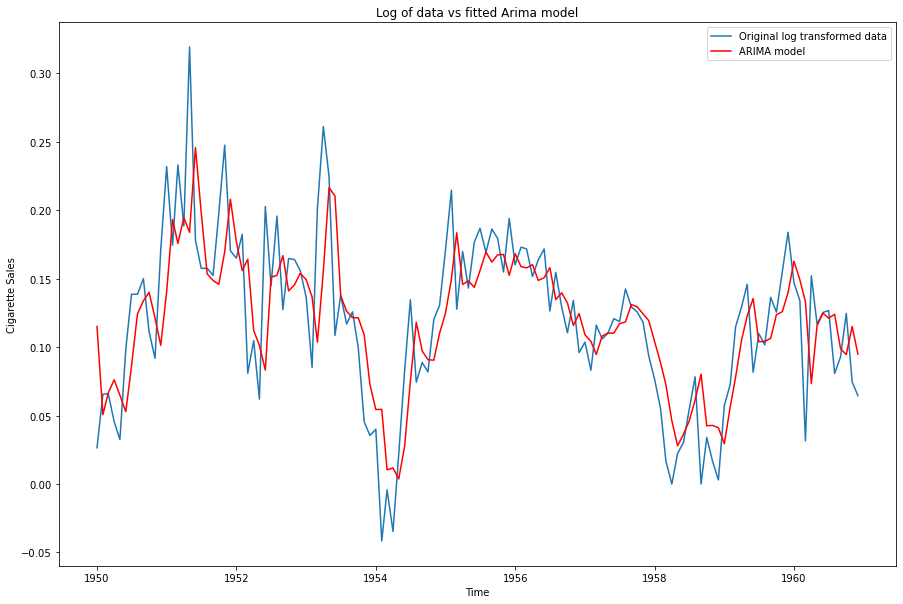

In [52]:
plt.figure(figsize=(15,10))
plt.plot(y_diff12, label='Original log transformed data')
plt.plot(model_fitted.predict(), color = 'red', label ='ARIMA model')
plt.title('Log of data vs fitted Arima model')
plt.xlabel('Time')
plt.ylabel('Cigarette Sales')
plt.legend()

From examining our arima model, it appears accurate without overfitting to the noise that appears.

### 3f. Application: Forecasting

We've done well: our model fits pretty closely to our existing data. Let's now use it to forecast what's likely to occur in future.

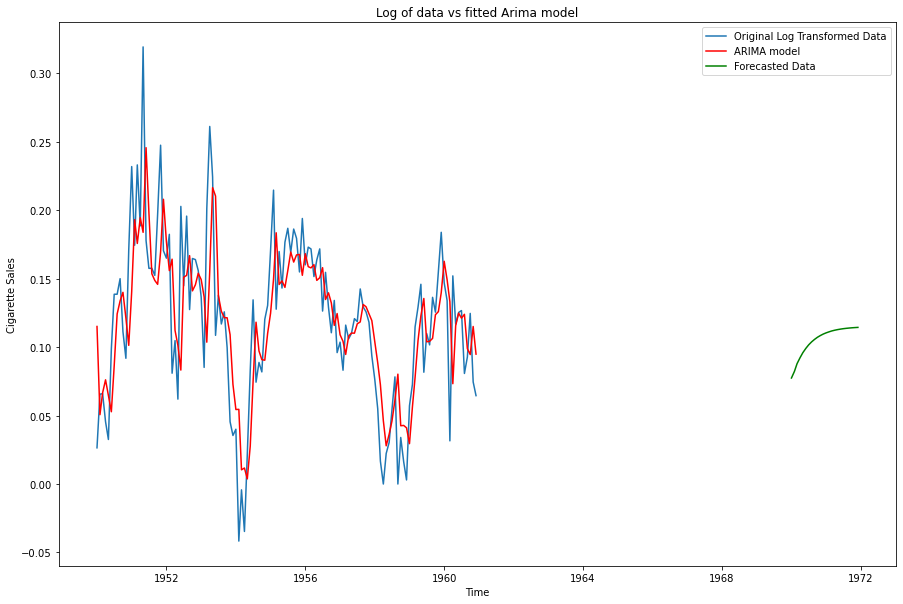

In [59]:
# Declare a variable called forecast_period with the amount of months to forecast, and
# create a range of future dates that is the length of the periods you've chosen to forecast
forecast_period = 24
date_range = pd.date_range(X_diff12.index[-1], periods = forecast_period, 
              freq='MS').strftime("%Y-%m-%d").tolist()

# Convert that range into a dataframe that includes your predictions
future_months = pd.DataFrame(date_range, columns = ['Month'])
# Let's now convert the 'Month' column to a datetime object with to_datetime 
future_months['Month'] = pd.to_datetime(future_months['Month'])
future_months.set_index('Month', inplace = True)
future_months['Prediction'] = forecast[0]
                         
# Plot your future predictions
plt.figure(figsize=(15,10))
plt.plot(y_diff12, label='Original Log Transformed Data')
plt.plot(model_fitted.predict(), color = 'red', label ='ARIMA model')
plt.plot(future_months , color = 'green', label='Forecasted Data')
plt.title('Log of data vs fitted Arima model')
plt.xlabel('Time')
plt.ylabel('Cigarette Sales')
plt.legend()

In [54]:
X_diff12

12    1950-01-01
13    1950-02-01
14    1950-03-01
15    1950-04-01
16    1950-05-01
         ...    
139   1960-08-01
140   1960-09-01
141   1960-10-01
142   1960-11-01
143   1960-12-01
Name: Month, Length: 132, dtype: datetime64[ns]

In [55]:
date_range

['1970-01-01',
 '1970-02-01',
 '1970-03-01',
 '1970-04-01',
 '1970-05-01',
 '1970-06-01',
 '1970-07-01',
 '1970-08-01',
 '1970-09-01',
 '1970-10-01',
 '1970-11-01',
 '1970-12-01',
 '1971-01-01',
 '1971-02-01',
 '1971-03-01',
 '1971-04-01',
 '1971-05-01',
 '1971-06-01',
 '1971-07-01',
 '1971-08-01',
 '1971-09-01',
 '1971-10-01',
 '1971-11-01',
 '1971-12-01']

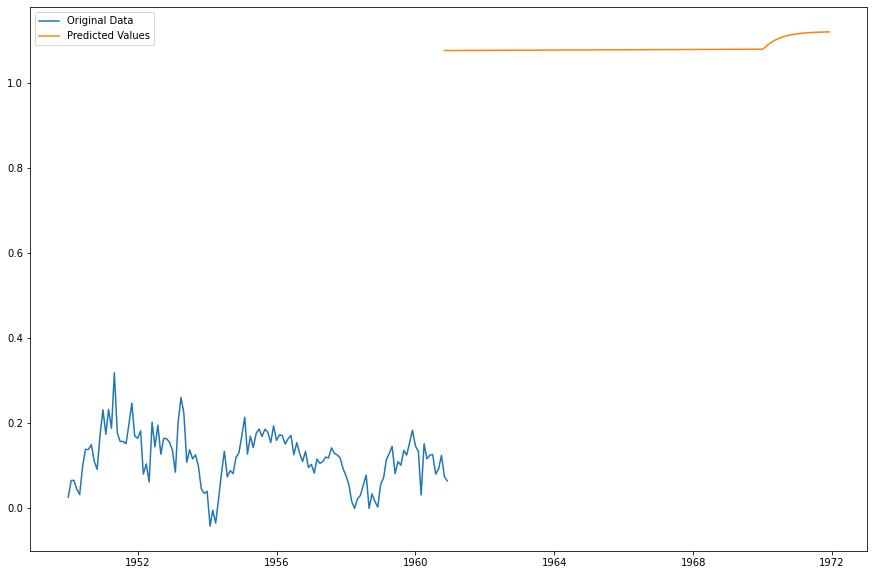

In [56]:
#plotting the original
plt.figure(figsize=(15,10))
plt.plot(y_diff12, label='Original Data')
plt.plot(np.exp(y_diff12['Nov 1960'].append(future_months['Prediction'])),
         label='Predicted Values')
plt.legend()
plt.show()

## 4. Evaluating and Concluding

Our model captures the centre of a line that's increasing at a remarkable rate. Cowboy Cigarettes sell more cigarettes in the summer, perhaps due to the good weather, disposable income and time off that people enjoy, and the least in the winter, when people might be spending less and enjoying less free time outdoors. 

Remarkably, our ARIMA model made predictions using just one variable. We can only speculate, however, on the causes of the behaviour predicted by our model. We should also take heed that spikes in data, due to sudden unusual circumstances like wars, are not handled well by ARIMA; and the outbreak of the Vietnam War in the 1960s would likely cause our model some distress.  

We could suggest to our employers that, if they are interested in discovering the causes of the cigarette sales trajectory, they execute a regression analysis in addition to the time series one. 